# Catmull-Rom Analysis
This Notebook contains all the analysis made directly on the Catmull-Rom CSV file.

## Libraries

In [553]:
library(tidyverse)
library(DT) # dependency
library(ggthemes) # dependency
library(plyr)

## Universal functions and variables

In [554]:
scenarios <- c("temperature", "rain", "sales", "gym_memberships", "wage", "facebook_friends")

readable_scenarios <- c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends")

subconditions = c(1, 2, 3)

condition_names = c("Prior", "Posterior-Straight", "Posterior-Negative", "Posterior-Positive")

In [555]:
get_range <- function(condition){
    
    range_array <- switch(
            condition,
            temperature = c(-10, 40),
            sales = c(0, 5000),
            facebook_friends = c(0, 1000),
            rain = c(0, 100),
            gym_memberships = c(0, 50),
            wage = c(0, 50)
        )
    
    range_value <- range_array[2] - range_array[1]
    
    delta <- range_value / 10
    
    c(range_array[1] - delta, range_array[2] + delta)

}

## Preparing the data

In [556]:
data <- suppressWarnings(read_csv("catmull-rom-dataset.csv"));

Parsed with column specification:
cols(
  .default = col_double(),
  userId = col_character(),
  age = col_character(),
  datetime = col_character(),
  gender = col_character(),
  datetime_1 = col_character(),
  stage = col_integer(),
  scenario = col_character(),
  subcondition = col_integer(),
  pageIndex = col_integer(),
  noiseIndex = col_integer(),
  day0 = col_character(),
  day1 = col_character(),
  day2 = col_character(),
  day3 = col_character(),
  day4 = col_character(),
  day5 = col_character(),
  day6 = col_character(),
  day7 = col_character(),
  day8 = col_character(),
  day9 = col_character()
  # ... with 69 more columns
)
See spec(...) for full column specifications.


In [557]:
tidy_data <- data %>% 
    gather(day, value, starts_with("day"))

# Transform the day columns to two columns: day and value
tidy_data$day <- as.numeric(gsub("day", "", tidy_data$day))

tidy_data$value <- as.numeric(tidy_data$value)

# Changes values to make them readable
# TODO: make this tidier:
tidy_data$subcondition_name <- mapvalues(tidy_data$subcondition,
                                  from = subconditions,
                                  to   = condition_names[2:4])

tidy_data$condition_name <- ifelse(tidy_data$stage==1,
                                   condition_names[1], 
                                   "")

tidy_data$condition_name <- ifelse(tidy_data$stage == 2, 
                                   tidy_data$subcondition_name, 
                                   tidy_data$condition_name)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

## Plot

PDF plots

In [558]:
dat <- data.frame(
                    id        = tidy_data$userId,
                    day       = tidy_data$day, #x
                    value     = tidy_data$value, #y
                    condition = tidy_data$condition_name,
                    scenario  = tidy_data$scenario
                 )

# Change the readable names of the variables
dat$scenario <- mapvalues( dat$scenario, 
                           from = scenarios,
                           to = readable_scenarios)


# Order on the plot
dat$condition <- factor( dat$condition, 
                         levels = condition_names)

dat$scenario <- factor( dat$scenario, 
                        levels = readable_scenarios)

# Subset the data to be shown
dat <- subset(dat, day > 30 & day < 365*4-30)

dplot <- subset(dat, day %in% seq(min(dat$day), max(dat$day), 25))

dm <- ddply(dat, ~scenario+condition+day, summarize, value=mean(value, trim=0.1))

dm$id <- "1"

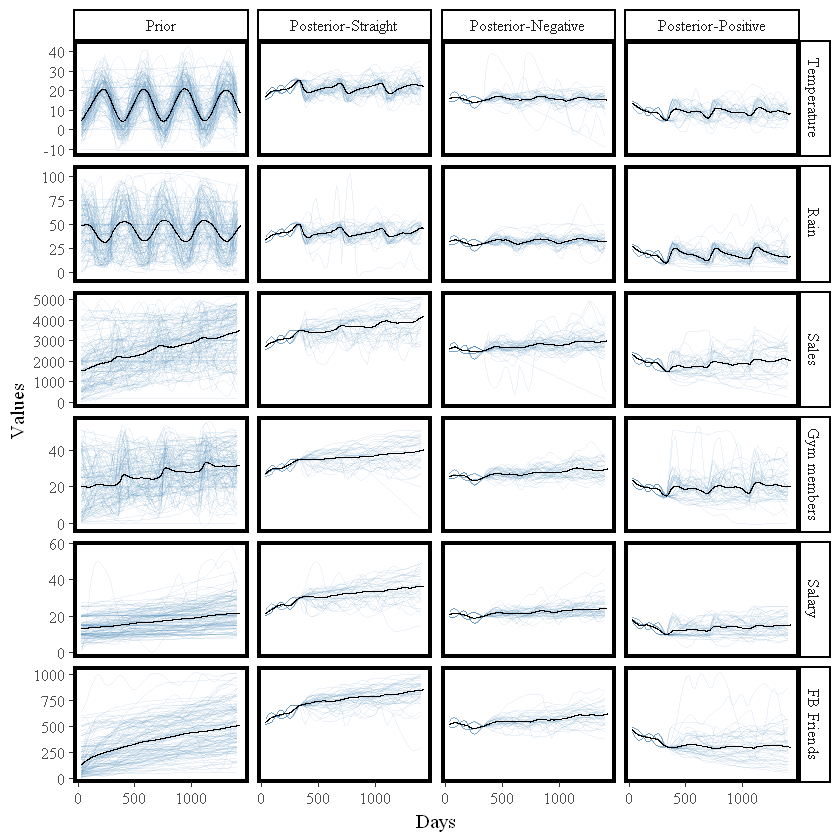

In [559]:
p <- ggplot(dplot, aes(x=day, y=value, group=id)) + 
     geom_line(col="steelblue", alpha=0.1) +
     facet_grid(scenario~condition, scales="free_y") +
     theme_classic() + 
     xlab("Days") + 
     ylab("Values") +
     geom_line(data=dm,aes(x=day,y=value),colour="black") +
     theme( text = element_text(size=12, family="serif"),
            panel.background = element_blank(),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            axis.line = element_line(colour = "black"),
            panel.border = element_rect(colour = "black", fill=NA, size=2))


#pdf("compforecasts.pdf")
p
#dev.off()